In [1]:
# a small tutorial on how to use the main class of the repo "PathShadowing"
# this is done on very bad generated data ("gaussian") so don't trust the results
# use this code with your own data (both generated and observed)
import os 
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

from scatspectra import PriceData, MRWGenerator
from shadowing import (
    Softmax, compute_smile, PathShadowing, 
    Foveal, RelativeMSE, PredictionContext, ArrayType
)
from shadowing.utils import windows
    
CACHE_PATH = Path(os.getcwd()) / '_cache'  # replace with your own cache path

def _torch(x: ArrayType) -> torch.Tensor:
    """ Convert x to a torch float tensor. """
    if isinstance(x, torch.Tensor):
        return x
    return torch.tensor(x, dtype=torch.float32)

# 1. Generated Dataset

The generated data to look for close time-series ("shadowing" paths).

You should come up with your own generated market data (log-prices). 

Here we generate data from a multifractal random walk (MRW) for simplicity,

of course, one should perform path shadowing in a more accurate model e.g. Scattering Spectra model. 

Model MRW: using cache directory MRW_B64_T4097_L4097_H5_0e_01_la2_0e_01.
Dataset shape (nb_long_time_series, nb_channels, nb_times):  (2048, 1, 4096)


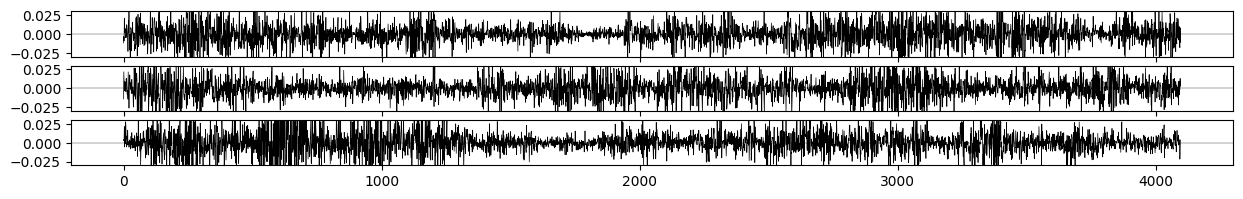

In [2]:
# create synthetic dataset
R = 2048

lnx_mrw = MRWGenerator(T=4096+1, H=0.5, lam=0.2, cache_path=CACHE_PATH).load(R=R)
dlnx_mrw = np.diff(lnx_mrw, axis=-1)
print("Dataset shape (nb_long_time_series, nb_channels, nb_times): ", dlnx_mrw.shape)

fig, axes = plt.subplots(3, 1, figsize=(15,2))
for i, ax in enumerate(axes):
    ax.plot(dlnx_mrw[i,0,:], color='black', linewidth=0.5)
    ax.axhline(0.0, color='black', linewidth=0.25)
    ax.set_ylim(-0.03,0.03)

Model MRW: generating data ...
Finished.
Context shape (nb_dates, nb_channels, nb_times):  (4, 1, 126)


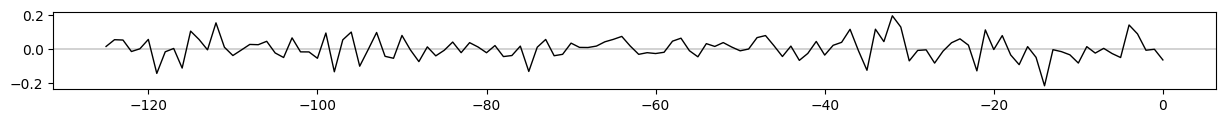

In [3]:
# observed data e.g. past time-series at different dates
# replace with the data you want to predict the future of
lnx_context = MRWGenerator(T=252+1, H=0.5, lam=0.2).load(R=1)
dlnx_context = np.diff(lnx_context, axis=-1)
dlnx_context = windows(dlnx_context, w=126, s=32)[0,0,:,None,:]
print("Context shape (nb_dates, nb_channels, nb_times): ", dlnx_context.shape)

plt.figure(figsize=(15,1))
plt.plot(np.arange(-126+1,1), dlnx_context[1,0,:], color='black', linewidth=1.0)
plt.axhline(0.0, color='black', linewidth=0.25);

# 2. Path Shadowing

Given observed log-returns gather the closest paths from the generated dataset.

In [4]:
# embedding for dimensionality reduction
embedding = Foveal(
    alpha=1.15,  # cover the past at exponential speed
    beta=0.9,  # look with a weight power-law decay of 0.9
    max_context=126  # look at half-year in the observed past
)

# distance between embedded paths
distance = RelativeMSE()

# object for path shadowing
obj = PathShadowing(
    embedding=embedding,
    distance=distance,
    dataset=dlnx_mrw,
    context=PredictionContext(horizon=252),  # the size of such paths in the future
)

# PERFORM PATH SHADOWING
distances, close_paths = obj.shadow(
    dlnx_context, 
    k=8192,  # the number of closest paths (from generated dataset) to retain 
    n_splits=8,
    cuda=False  # set to True, if GPU available, for accelarations
)

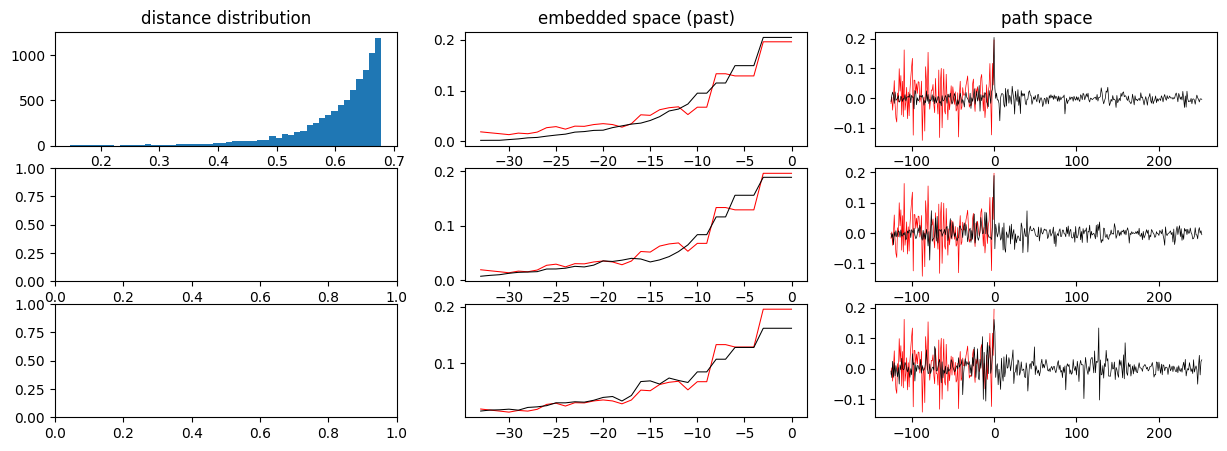

In [5]:
# some vizualization
i_date = 0

context_size = dlnx_context.shape[-1]  # nb of days in the past
d = embedding.dim  # embedding dimension
horizon = 252

# get 3 closest paths at this date
idces = np.argpartition(distances[i_date,:], 3)[:3]
dlnx_closest = np.stack([close_paths[i_date][i_path] for i_path in idces])

# embed them
dlnx_context_emb = embedding(_torch(dlnx_context))
dlnx_closest_emb = embedding(_torch(dlnx_closest))

fig, axes = plt.subplots(3, 3, figsize=(15, 5))
axes[0,0].set_title('distance distribution')
axes[0,0].hist(distances[i_date], bins=50)
axes[0,1].set_title('embedded space (past)')
for i, ax in enumerate(axes[:,1]):
    ts_past = np.arange(-d+1, 1)
    ax.plot(ts_past, dlnx_context_emb[i_date,0,:].flip(-1), color='red', linewidth=0.75)
    ax.plot(ts_past, dlnx_closest_emb[i,0,:].flip(-1), color='black', linewidth=0.75)
axes[0,2].set_title('path space')
for i, ax in enumerate(axes[:,2]):
    ts_past = np.arange(-context_size+1,1)
    ts = np.arange(-context_size+1,horizon+1)
    ax.plot(ts_past, dlnx_context[i_date,0,:], color='red', linewidth=0.5)
    ax.plot(ts, dlnx_closest[i,0,:], color='black', linewidth=0.5)


# Volatility Prediction

In [11]:
from shadowing.statistics import realized_variance

# maturities 
Ts = np.array([7,25,75])

# the quantity to predict, should be a function of paths returning an array of statistics
# e.g. realized variance, takes a path, return a scalar per maturity
to_predict = lambda dlnx: realized_variance(dlnx, Ts=Ts, vol=True)

# perform prediction by averaging over the k closest paths for each prediction date
# see method 'predict' for more direct way 
predictions, _ = obj.predict_from_paths(
    distances, 
    close_paths, 
    to_predict=to_predict,
    proba_name="softmax",
    eta=0.1
)

print(f"n_dates={predictions.shape[0]}, nb_maturities={predictions.shape[1]}")

n_dates=4, nb_maturities=3


# Option Pricing

Shows how to perform option pricing in two contexts


In [7]:
Ts = np.array([7,25,75])  # maturities in days
Ms = np.linspace(-2.0,2.0,9)  # rescaled log-moneyness
r = 0.00  # interest rate

### Smile at a given date

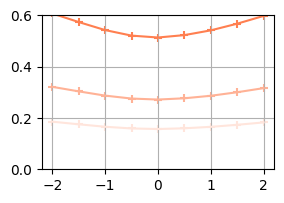

In [8]:
i_date = 0

# averaging operator in Hedged HMC
ave = Softmax(distances[i_date,:], eta=0.075)

# the shadowing paths extending the currently observed past
x = PriceData(dlnx=close_paths[i_date,:,0,context_size:], x_init=100.0).x

# HMC on such shadowing paths
smile_conditional = compute_smile(x, Ts, Ms, r, ave)

# plotting
_, ax = plt.subplots(1, 1, figsize=(3,2))
smile_conditional.plot(ax=ax, color='coral', rescale=True)
ax.set_ylim(0.0,0.6);

### Average Smile

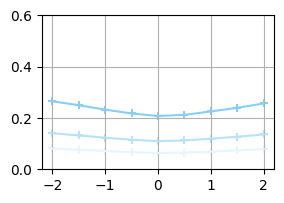

In [9]:
# snippets of MRW price trajectories
lnx_mrw_snippets = windows(lnx_mrw[0,0,:], w=252, s=1)
x = PriceData(lnx=lnx_mrw_snippets, x_init=100.0).x

# HMC on such snippets
smile_avg = compute_smile(x, Ts, Ms, r, ave=None)

# plotting
_, ax = plt.subplots(1, 1, figsize=(3,2))
smile_avg.plot(ax=ax, color='lightskyblue', rescale=True)
ax.set_ylim(0.0,0.6);